<a href="https://colab.research.google.com/github/Vreyka/AIVN_learning_path/blob/main/Research/Eco/DL/LSTM_nowcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score


Kích thước dữ liệu mục tiêu: (10000, 1)
Kích thước dữ liệu chỉ báo: (10000, 3)


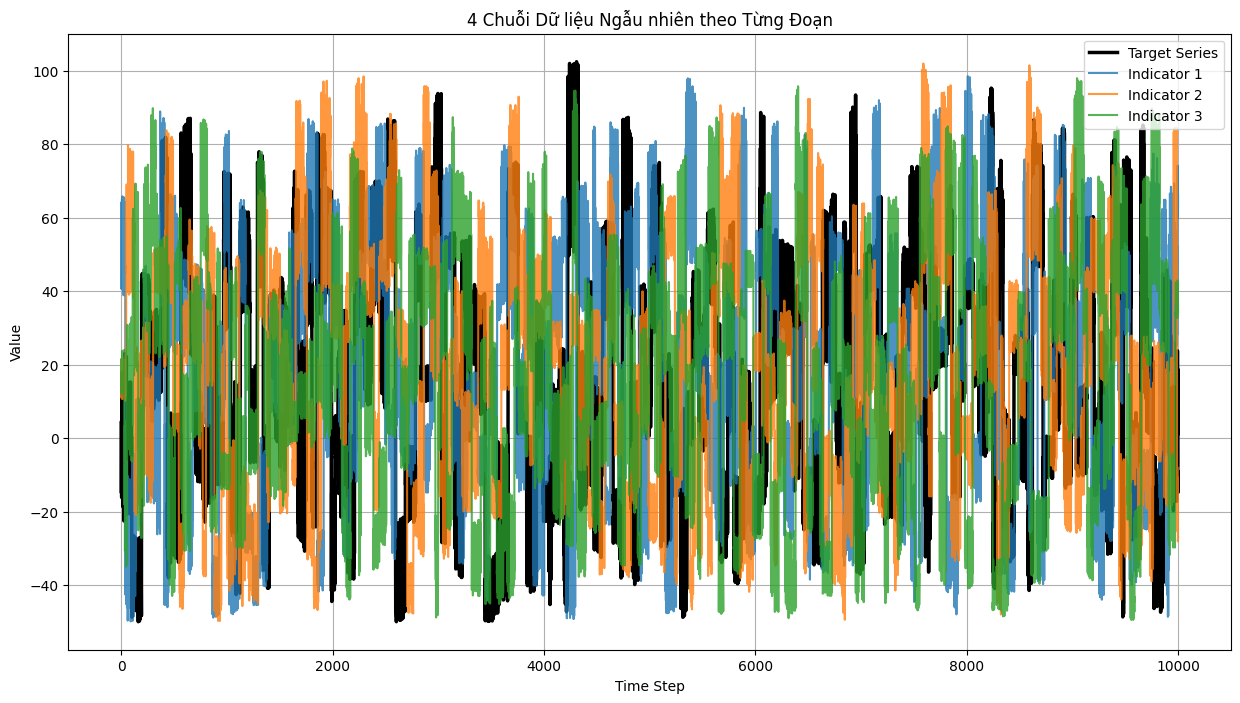

In [24]:


def generate_segmented_series(timestep):
    """
    Hàm trợ giúp: Tạo ra MỘT chuỗi ngẫu nhiên theo từng đoạn.
    Đây là logic cốt lõi từ Code (1) của bạn, đã được sửa lỗi cú pháp.
    """
    data = []
    total = 0
    while total < timestep:
        # Random độ dài của đoạn
        elaps = np.random.randint(20, 100)
        if total + elaps > timestep:
            elaps = timestep - total

        # Random khoảng giá trị cho đoạn này
        low = np.random.randint(-50, 50)
        high = low + np.random.randint(10, 60)

        # Sinh giá trị ngẫu nhiên (dạng số thực) trong khoảng [low, high)
        segment_data = np.random.uniform(low, high, size=elaps)
        data.extend(segment_data)
        total += elaps

    return np.array(data)

def create_4_segmented_series(timestep):
    """
    Hàm chính: Tạo ra 4 chuỗi riêng biệt, mỗi chuỗi có cấu trúc theo đoạn.
    """
    # 1. Tạo chuỗi mục tiêu (bộ thứ 4)
    target_series = generate_segmented_series(timestep)

    # 2. Tạo 3 chuỗi chỉ báo
    indicator_1 = generate_segmented_series(timestep)
    indicator_2 = generate_segmented_series(timestep)
    indicator_3 = generate_segmented_series(timestep)

    # 3. Ghép 3 chuỗi chỉ báo lại với nhau
    indicators = np.vstack([indicator_1, indicator_2, indicator_3]).T

    return target_series.reshape(-1, 1), indicators

# --- Sử dụng ---
timestep = 10000
target_data, indicator_data = create_4_segmented_series(timestep)

# --- Vẽ biểu đồ để xem xét ---
print("Kích thước dữ liệu mục tiêu:", target_data.shape)
print("Kích thước dữ liệu chỉ báo:", indicator_data.shape)

plt.figure(figsize=(15, 8))
plt.title("4 Chuỗi Dữ liệu Ngẫu nhiên theo Từng Đoạn")
plt.plot(target_data, label="Target Series", linewidth=2.5, color='black')
plt.plot(indicator_data[:, 0], label="Indicator 1", linestyle='-', alpha=0.8)
plt.plot(indicator_data[:, 1], label="Indicator 2", linestyle='-', alpha=0.8)
plt.plot(indicator_data[:, 2], label="Indicator 3", linestyle='-', alpha=0.8)
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
def create_nowcasting_sequences(indicators, target, seq_len):
    xs, ys = [], []
    for i in range(len(indicators) - seq_len):
        x = indicators[i:(i + seq_len)]; y = target[i + seq_len]
        xs.append(x); ys.append(y)
    return np.array(xs), np.array(ys)

# =================================================================
# BƯỚC 1: TẠO FEATURE BỊ TRỄ (LAGGED FEATURE) BẰNG NUMPY
# =================================================================
# Tạo một mảng mới 'target_lagged', trong đó mỗi phần tử là giá trị của
# 'target_data' ở bước thời gian trước đó.
# Điền NaN vào vị trí đầu tiên vì không có giá trị t-1.
nan_value = np.array([[np.nan]])
target_lagged = np.concatenate([nan_value, target_data[:-1]])


# =================================================================
# BƯỚC 2: GHÉP CÁC BIẾN ĐẦU VÀO VÀ XỬ LÝ NaN
# =================================================================
# Ghép các chỉ báo với target đã bị trễ.
# Đây là bộ dữ liệu đầu vào thô, có 4 cột.
all_inputs = np.hstack([indicator_data, target_lagged])

# Xóa hàng đầu tiên của bộ dữ liệu đầu vào vì nó chứa NaN
X_data_unscaled = all_inputs[1:]

# Đồng thời, cũng phải xóa hàng đầu tiên của dữ liệu mục tiêu để giữ sự đồng bộ
y_data_unscaled = target_data[1:]

# =================================================================
# BƯỚC 3: CHUẨN HÓA DỮ LIỆU SAU KHI ĐÃ CĂN CHỈNH
# =================================================================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Chuẩn hóa dữ liệu đầu vào (4 features) và dữ liệu mục tiêu
X_scaled = scaler_X.fit_transform(X_data_unscaled)
y_scaled = scaler_y.fit_transform(y_data_unscaled)

seq_len = 100

X, y = create_nowcasting_sequences(X_scaled, y_scaled, seq_len)

print("Kích thước X sau khi tạo chuỗi:", X.shape)
print("Kích thước y sau khi tạo chuỗi:", y.shape)


train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)


Kích thước X sau khi tạo chuỗi: (9899, 100, 4)
Kích thước y sau khi tạo chuỗi: (9899, 1)


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x); out = self.linear(out[:, -1, :]); return out

def train_model(model, criterion, optimizer, train_loader, epochs=50):
    for epoch in range(epochs):
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad(); output = model(xb)
            loss = criterion(output, yb)
            loss.backward(); optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.5f}")

model = LSTMModel(input_size=4, hidden_size=128, num_layers=2).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

LSTMModel(
  (lstm): LSTM(4, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

In [27]:
train_model(model, criterion, optimizer, train_loader, epochs=500)

Epoch 10/500, Loss: 0.00818
Epoch 20/500, Loss: 0.01209
Epoch 30/500, Loss: 0.02406
Epoch 40/500, Loss: 0.00972
Epoch 50/500, Loss: 0.00208
Epoch 60/500, Loss: 0.00621
Epoch 70/500, Loss: 0.01091
Epoch 80/500, Loss: 0.00501
Epoch 90/500, Loss: 0.01314
Epoch 100/500, Loss: 0.00677
Epoch 110/500, Loss: 0.00798
Epoch 120/500, Loss: 0.01101
Epoch 130/500, Loss: 0.00200
Epoch 140/500, Loss: 0.00266
Epoch 150/500, Loss: 0.00198
Epoch 160/500, Loss: 0.00200
Epoch 170/500, Loss: 0.00129
Epoch 180/500, Loss: 0.00082
Epoch 190/500, Loss: 0.00050
Epoch 200/500, Loss: 0.00034
Epoch 210/500, Loss: 0.00046
Epoch 220/500, Loss: 0.00026
Epoch 230/500, Loss: 0.00018
Epoch 240/500, Loss: 0.00009
Epoch 250/500, Loss: 0.00023
Epoch 260/500, Loss: 0.00025
Epoch 270/500, Loss: 0.00015
Epoch 280/500, Loss: 0.00024
Epoch 290/500, Loss: 0.00018
Epoch 300/500, Loss: 0.00012
Epoch 310/500, Loss: 0.00004
Epoch 320/500, Loss: 0.00011
Epoch 330/500, Loss: 0.00012
Epoch 340/500, Loss: 0.00008
Epoch 350/500, Loss: 0.


Đang vẽ biểu đồ so sánh kết quả...


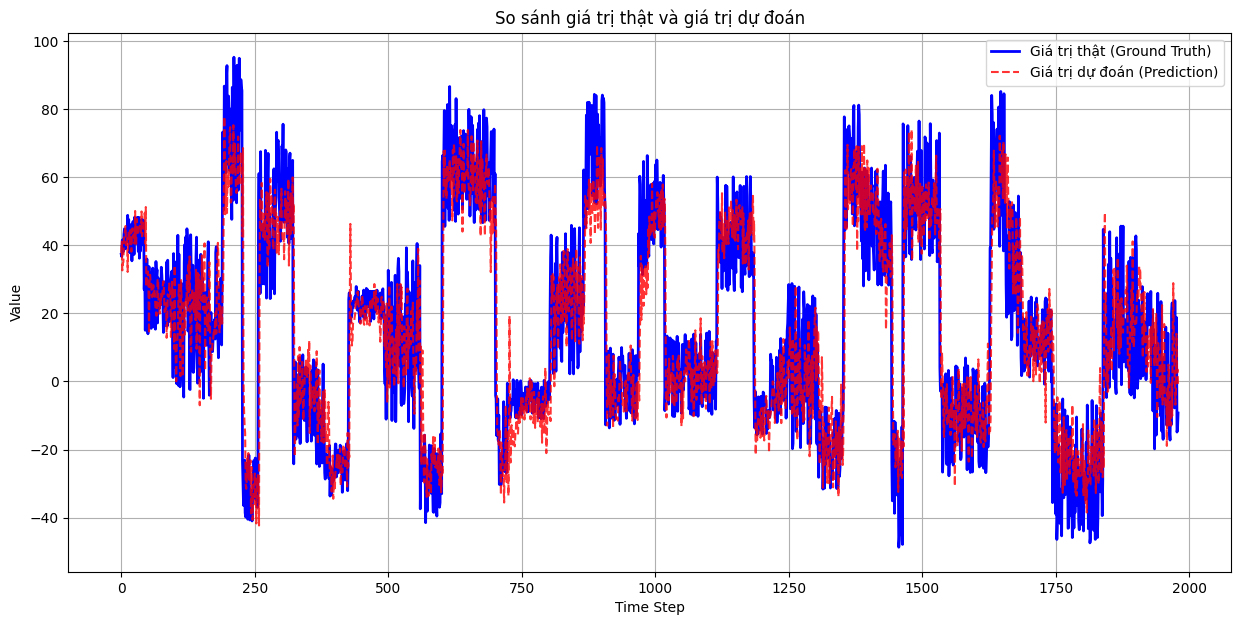

In [28]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# =================================================================
# BƯỚC 1: CHUẨN BỊ ĐÁNH GIÁ
# =================================================================

# Đảm bảo 'device' đã được định nghĩa (GPU hoặc CPU)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Đặt model ở chế độ đánh giá (quan trọng!)
# Chế độ này sẽ tắt các lớp như Dropout, BatchNorm, etc.
model.eval()

# =================================================================
# BƯỚC 2: DỰ ĐOÁN TRÊN BỘ DỮ LIỆU TEST
# =================================================================

# Không cần tính toán gradient khi đánh giá
with torch.no_grad():
    # Chuyển dữ liệu test lên cùng thiết bị với model
    X_test_tensor = X_test_tensor.to(device)

    # Lấy kết quả dự đoán (dạng đã được chuẩn hóa)
    y_pred_scaled = model(X_test_tensor)

# =================================================================
# BƯỚC 3: CHUYỂN DỮ LIỆU VỀ CPU VÀ BIẾN ĐỔI NGƯỢC
# =================================================================

# Chuyển dữ liệu dự đoán về CPU để có thể dùng với NumPy và Scikit-learn
# Nếu model của bạn đã ở trên CPU, bước này không ảnh hưởng
y_pred_cpu = y_pred_scaled.cpu().numpy()

# Chuyển dữ liệu thật về CPU
y_true_cpu = y_test_tensor.cpu().numpy()

# Dùng scaler của target (y) để biến đổi ngược về thang đo ban đầu
# scaler_y phải là scaler đã fit trên dữ liệu y trước đó
y_pred_inv = scaler_y.inverse_transform(y_pred_cpu)
y_true_inv = scaler_y.inverse_transform(y_true_cpu)


# =================================================================
# BƯỚC 4: VẼ BIỂU ĐỒ SO SÁNH
# =================================================================
print("\nĐang vẽ biểu đồ so sánh kết quả...")

plt.figure(figsize=(15, 7))
plt.title("So sánh giá trị thật và giá trị dự đoán")

# Chỉ vẽ biểu đồ của chuỗi mục tiêu
plt.plot(y_true_inv, label="Giá trị thật (Ground Truth)", color="blue", linewidth=2)
plt.plot(y_pred_inv, label="Giá trị dự đoán (Prediction)", color="red", linestyle='--', alpha=0.8)

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
r2 = r2_score(y_true_inv, y_pred_inv)

# In kết quả ra màn hình
print(f"\n📊 Chỉ số R-squared (R²): {r2:.4f}")

# Giải thích ngắn gọn kết quả
if r2 < 0.1:
    print("-> Kết quả R² rất thấp, cho thấy mô hình hoạt động không hiệu quả và gần như không học được quy luật gì.")
elif r2 < 0.5:
    print("-> Kết quả R² ở mức thấp, mô hình chỉ giải thích được một phần nhỏ sự biến thiên của dữ liệu.")
else:
    print("-> Kết quả R² ở mức khá, mô hình có khả năng dự báo nhất định.")


📊 Chỉ số R-squared (R²): 0.7108
-> Kết quả R² ở mức khá, mô hình có khả năng dự báo nhất định.
